# ESA CCI Biomass V5.01 — Access and Visualization (Token-secured)

Authors: Rajat Shinde (UAH), Alex Mandel (Development Seed), Sheyenne Kirkland (UAH), Harshini Girish (UAH), Jamison French (Development Seed), Henry Rodman (Development Seed), Chuck Daniels (Development Seed), Zac Deziel (Development Seed), Brian Freitag (NASA)

Date: August 29, 2025

Description: This notebook documents how to access and visualize the ESA CCI Biomass V5.01 dataset hosted on the ESA MAAP server. It is an example illustrating data access from ESA server based on ESA MAAP Token using the NASA MAAP Authorization.



## What you will do
1. Understand the product and file organization.  
2. Obtain an ESA access token.  
3. Access a V5.01 raster using the token.  
4. Visualize in Python.  



## Run This Notebook

To access and run this tutorial within MAAP’s Algorithm Development Environment (ADE), please refer to the [Getting started with the MAAP](#) section of our documentation.

**Disclaimer**: It is highly recommended to run this tutorial within MAAP’s ADE, which already includes packages specific to MAAP, such as maap-py. Running the tutorial outside of the MAAP ADE may lead to errors.

**Prerequisites**  
- An active ESA MAAP portal account with access initialized.  
- OAuth2 client credentials for your ESA realm.  
- Python packages: `requests`, `rasterio`, `numpy`, `matplotlib` (optional: `pystac-client`, `stackstac`).  


## Importing and Installing Packages

In [1]:
# Install if needed. Comment out if already available.
# !mamba install -y -c conda-forge rasterio xarray matplotlib fsspec requests
# !pip install pystac-client stackstac

import os
import stat
import getpass
import pathlib

import requests
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt

import rasterio as rio
from rasterio.merge import merge
from rasterio.plot import show
from affine import Affine

from pystac_client import Client


plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams["axes.grid"] = False

## Getting the Token from the ESA MAAP portal

This explains how to retrieve a short-lived access token from the ESA MAAP portal using your browser and NASA EDL login.

Open the token page in your browser:
**https://portal.maap.eo.esa.int/ini/services/auth/token/**

**Steps**
1. Navigate to the URL above.  
2. Choose **NASA Earthdata Login (EDL)** when prompted and authorize access.  
3. After successful authorization you will see a **token page** showing your short‑lived access token string.

**The below screenshots illustrate the process for each steps.**
- **Portal entry page**:  
  ![Portal](./images/esa_maap.jpg)
- **NASA EDL authorization screen**:  
  ![NASA EDL](./images/page2.jpg)
- **Token page after authorization**:  
  ![Token Page](./images/page3.jpg)

**Copy the token value** from the token page for use in the next cell.

**Notes**
- Tokens are short‑lived. If you see **401 Unauthorized** later, refresh the token using the same URL and update the value in the notebook.
- Treat tokens as secrets. Do not commit them to version control or share publicly.

Now we paste the token we got from the portal and save it to a file so it can be used later in the notebook.

In [2]:
TOKEN_FILE = pathlib.Path.home() / ".config" / "esa_maap" / "tokens"
TOKEN_FILE.parent.mkdir(parents=True, exist_ok=True)

if not TOKEN_FILE.exists():
    tok = getpass.getpass("Paste ESA portal token (hidden): ").strip()
    if not tok:
        raise ValueError("Empty token.")
    TOKEN_FILE.write_text(tok, encoding="utf-8")
    
    TOKEN_FILE.chmod(stat.S_IRUSR | stat.S_IWUSR)


st = TOKEN_FILE.stat()
if (st.st_mode & 0o777) != 0o600:
    raise PermissionError(f"{TOKEN_FILE} must have mode 600. Fix with: chmod 600 {TOKEN_FILE}")

ESA_TOKEN = TOKEN_FILE.read_text(encoding="utf-8").strip()
print("Token loaded from file:", TOKEN_FILE)


Paste ESA portal token (hidden):  ········


Token loaded from file: /projects/.config/esa_maap/tokenss


## Discover tiles via ESA STAC

Now, we will query the ESA STAC API for CCIBiomassV5.01 over the given bounding box and time range, and then select the COG data assets URLs for this AOI and time range. We handle pagination, prefer assets labeled as COG data, and record the AOI window for efficient partial reads.



In [3]:
STAC_URL = "https://catalog.maap.eo.esa.int/catalogue/"
COLLECTION = "CCIBiomassV5.01"
BBOX = [10.0, 0.0, 10.6, 0.6]               
DT = "2010-01-01/2010-12-31"

In [4]:
api   = Client.open(STAC_URL)
items = list(api.search(collections="CCIBiomassV5.01", bbox=BBOX, datetime=DT, limit=10).get_items())
hrefs = []
for it in items:
    for a in it.assets.values():
        if (a.media_type and "geotiff" in a.media_type.lower()) or a.href.lower().endswith(".tif"):
            hrefs.append(a.href)
assert hrefs, "No GeoTIFF assets found for AOI/year."

## Creating a Mosaic

Open the selected COG tiles with token-auth, then merge them within the AOI (BBOX) to build a single mosaic. Record the nodata value from the first source and close all datasets to free handles.

In [5]:
with rio.Env(GDAL_HTTP_HEADERS=f"Authorization: Bearer {ESA_TOKEN}",
             GDAL_DISABLE_READDIR_ON_OPEN="EMPTY_DIR", GDAL_NUM_THREADS="ALL_CPUS"):
    srcs = [rio.open(h) for h in hrefs]
    mosaic, out_transform = merge(srcs, bounds=BBOX)   # mosaic: (bands, y, x)
    nodata = srcs[0].nodatavals[0]
    for s in srcs: s.close()

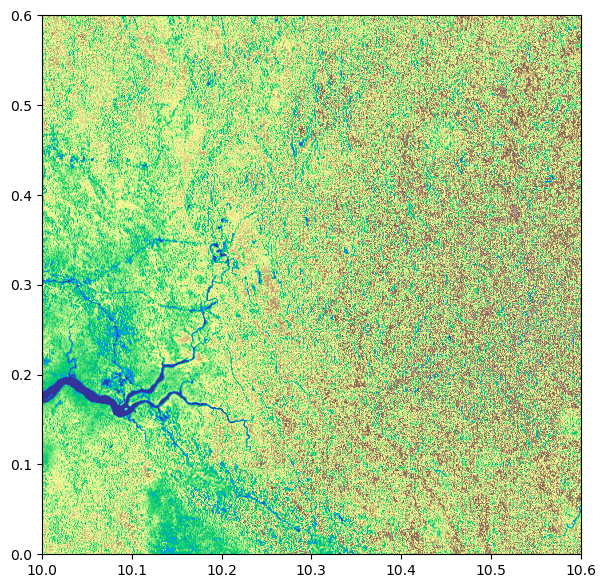

In [26]:
mosaic_band = mosaic[0]

if nodata is not None:
    masked = ma.masked_where(np.isclose(mosaic_band, nodata), mosaic_band)
else:
    masked = ma.masked_invalid(mosaic_band)

fig, ax = plt.subplots(figsize=(7, 7))
img = show(masked, transform=out_transform, cmap="terrain", ax=ax)

## Saving Tile as COG

Finally, we can save the tile as COG locally. We validate tiling, block size, compression, and overview count here.

In [7]:
assert 'mosaic' in globals() and 'out_transform' in globals(), "Run the mosaic cell first."

out_cog = "cci_biomass_v5_mosaic_cog.tif"


is_float = np.issubdtype(mosaic.dtype, np.floating)

def _is_number(x):
    try:
        return x is not None and not (isinstance(x, float) and np.isnan(x))
    except Exception:
        return False

if _is_number(nodata):
    fill_value = int(nodata) if not is_float else float(nodata)
    write_nodata = fill_value
else:
    # Source had no nodata; pick a safe default
    fill_value = np.nan if is_float else -9999
    write_nodata = None if is_float else -9999  # for floats we can just keep NaNs

# Use masked array if it exists, otherwise write the raw mosaic
to_write = masked.filled(fill_value).astype(mosaic.dtype) if 'masked' in globals() else mosaic

profile = {
    "driver": "COG",
    "dtype": to_write.dtype.name,
    "count": to_write.shape[0],
    "height": to_write.shape[1],
    "width":  to_write.shape[2],
    "crs": "EPSG:4326",
    "transform": out_transform,
    "nodata": write_nodata,
}

cog_opts = {
    "BLOCKSIZE": "512",
    "COMPRESS": "LZW",
    "OVERVIEWS": "AUTO",
    "NUM_THREADS": "ALL_CPUS",
    "RESAMPLING": "NEAREST",
}

with rio.open(out_cog, "w", **profile, **cog_opts) as dst:
    dst.write(to_write)

with rio.open(out_cog) as ds:
    print({
        "driver": ds.driver,
        "dtype": ds.dtypes[0],
        "tiled": ds.profile.get("tiled"),
        "block": (ds.profile.get("blockxsize"), ds.profile.get("blockysize")),
        "compress": ds.profile.get("compress"),
        "overviews": ds.overviews(1),
        "nodata": ds.nodata,
    })



{'driver': 'GTiff', 'dtype': 'uint16', 'tiled': True, 'block': (512, 512), 'compress': 'lzw', 'overviews': [2], 'nodata': None}


Here we make a request to the example tile using the token to check that authentication is working.

In [13]:
# Use the first item from our STAC query as an example tile
assert hrefs, "No GeoTIFF assets found for AOI/year."
V5_EXAMPLE_URL = hrefs[1]

print("Using example tile from STAC query:", V5_EXAMPLE_URL)


Using example tile from STAC query: https://catalog.maap.eo.esa.int/data/biomass-maap-01/CCIBiomassV5.01/2010/01/01/N10E010_ESACCI-BIOMASS-L4-AGB-MERGED-100m-2010-fv5.0/N10E010_ESACCI-BIOMASS-L4-AGB-MERGED-100m-2010-fv5.0.tif


In [14]:
headers = {"Authorization": f"Bearer {ESA_TOKEN}"}
r = requests.get(V5_EXAMPLE_URL, headers=headers, stream=True)

print("HTTP status:", r.status_code)
if r.status_code == 403:
    print(
        "403 Forbidden: Your account may need initialization for this collection.\n"
        "Follow any initialization link provided by the server, refresh the token, and retry."
    )
elif r.status_code == 401:
    print("401 Unauthorized: Token expired or invalid. Get a new token at the portal URL and update ESA_TOKEN.")
elif r.status_code != 200:
    print("Unexpected status. Check URL, permissions, or try another tile/year.")
else:
    print("Access OK.")


HTTP status: 200
Access OK.


Value range: 0.0 899.0


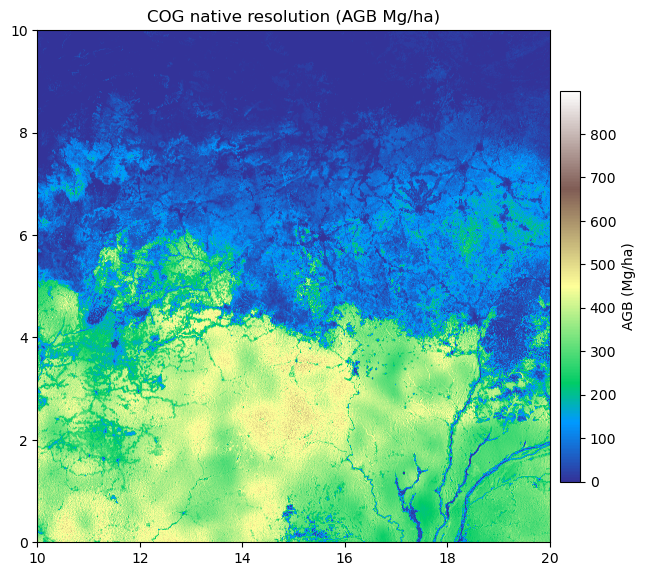

In [25]:
env = {"GDAL_HTTP_HEADERS": f"Authorization: Bearer {ESA_TOKEN}"}

with rio.Env(**env):
    with rio.open(V5_EXAMPLE_URL) as ds:
        arr = ds.read(1, masked=True)

        # Apply scale/offset if present
        scale  = (ds.scales  or [1.0])[0]
        offset = (ds.offsets or [0.0])[0]
        arr = arr * scale + offset

        # Full-range limits
        v = arr.compressed()
        vmin, vmax = (v.min(), v.max()) if v.size else (None, None)
        print("Value range:", vmin, vmax)

        # Plot like your first figure (rasterio.show, north-up, georeferenced)
        fig, ax = plt.subplots(figsize=(7, 7))
        ax = show(arr, transform=ds.transform, cmap="terrain", vmin=vmin, vmax=vmax, ax=ax)
        im = ax.images[0]  # image added by rasterio.show
        cbar = plt.colorbar(im, ax=ax, fraction=0.036, pad=0.02)
        cbar.set_label("AGB (Mg/ha)")
        ax.set_title("COG native resolution (AGB Mg/ha)")
